## Lab 3.1 – Skin Cancer classification: MobileNet (Teachable Machine)

This notebook is used to evaluate the performance of skin cancer classification models trained on Teachable Machine.

Dataset consisting of 7 classes: Melanoma(MEL), Melanocytic nevi(NV), Basal cell carcinoma(BCC), Actinic keratoses(AKIEC), Benign keratosis lesions(BKL), Dermatofibroma(DF), and Vascular lesions(VASC)

This example code will consist of:

0. **Setup**
1. **Load Model**
2. **Load Data**
3. **Inference & Evaluate**

## 0) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [ ]:
# Download Prepared dataset from github
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
!unzip -q -o 'Ham10000_torch.zip'

# Download library
!pip install --upgrade tensorflow

--2025-12-29 11:28:39--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip [following]
--2025-12-29 11:28:39--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94841947 (90M) [application/zip]
Saving to: ‘Ham10000_torch.zip’

Ham10000_torch.zip  100%[===================>]  90.45M  44.1MB/s    in 2.1s    

2025-12-29 11:28:41 (44.1 M

In [ ]:
# Import library
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import DepthwiseConv2D
from keras.models import load_model

from PIL import Image, ImageOps
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## 1) Load Model
Load models trained on Teachable Machine

The image model in Teachable Machine is MobileNet, which is built using TensorFlow.

In [ ]:
!unzip -q -o '/content/TM_keras.zip'

In [ ]:
np.set_printoptions(suppress=True)
class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop("groups", None)
        super().__init__(*args, **kwargs)

wegihts_path = "/content/keras_model.h5" # @param {type:"string"}
model = load_model(
    wegihts_path,
    custom_objects={"DepthwiseConv2D": FixedDepthwiseConv2D},
    compile=False
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2) Load Data

In [ ]:
with open("labels.txt", "r") as f:
    class_names = [line.strip()[2:] for line in f.readlines()]

In [ ]:
# Load data
df=pd.read_csv('/content/GroundTruth.csv')
df['image']=df['image'].apply(lambda x: "/content/images/"+x+ '.jpg')
df = df.drop(columns=["Unnamed: 0"])

lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

labels = list(df.columns[1:])
label_list=[]
full_label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)

    full_label=lesion_type_dict[labels[index]]
    full_label_list.append(full_label)
df['label']= label_list
df['full_label']= full_label_list

train_df, val_df, test_df = df[:210], df[210:280], df[280:350]

print('Data Test:', len(test_df))
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

test_df.head()

Data Test: 70


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,full_label
0,/content/images/ISIC_0024767.jpg,1,0,0,0,0,0,0,MEL,Melanoma
1,/content/images/ISIC_0024365.jpg,0,1,0,0,0,0,0,NV,Melanocytic nevi
2,/content/images/ISIC_0024949.jpg,0,0,1,0,0,0,0,BCC,Basal cell carcinoma
3,/content/images/ISIC_0025368.jpg,0,0,0,1,0,0,0,AKIEC,Actinic keratoses
4,/content/images/ISIC_0024705.jpg,0,0,0,0,1,0,0,BKL,Benign keratosis lesions


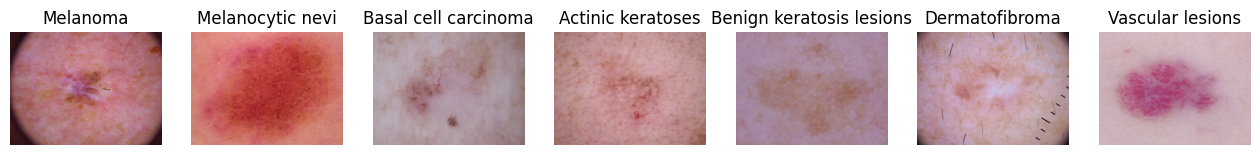

In [ ]:
# Example image
plt.figure(figsize=(16, 14))
for j in range(7):
  plt.subplot(1,7,j+1)
  plt.imshow(mpimg.imread(test_df.image[j]))
  plt.axis("off")
  plt.title(test_df.full_label[j])

## 3) Inference & Evaluate

In [ ]:
# Inference
output_list = []
confidence_score_list = []
for i in range(len(test_df)):
  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
  # Replace this with the path to your image
  image = Image.open(test_df.image[i]).convert("RGB")
  # resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
  # turn the image into a numpy array
  image_array = np.asarray(image)
  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
  # Load the image into the array
  data[0] = normalized_image_array
  # Predicts the model
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  output_list.append(class_name)
  confidence_score_list.append(confidence_score)

test_df['output']= output_list
test_df['confidence']= confidence_score_list
test_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

/tmp/ipython-input-4254543448.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['output']= output_list
/tmp/ipython-input-4254543448.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['confidence']= confidence_score_list


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,full_label,output,confidence
0,/content/images/ISIC_0024767.jpg,1,0,0,0,0,0,0,MEL,Melanoma,BKL,0.728131
1,/content/images/ISIC_0024365.jpg,0,1,0,0,0,0,0,NV,Melanocytic nevi,BKL,0.817548
2,/content/images/ISIC_0024949.jpg,0,0,1,0,0,0,0,BCC,Basal cell carcinoma,BCC,0.979446
3,/content/images/ISIC_0025368.jpg,0,0,0,1,0,0,0,AKIEC,Actinic keratoses,BCC,0.797852
4,/content/images/ISIC_0024705.jpg,0,0,0,0,1,0,0,BKL,Benign keratosis lesions,DF,0.333881
...,...,...,...,...,...,...,...,...,...,...,...,...
65,/content/images/ISIC_0025285.jpg,0,0,1,0,0,0,0,BCC,Basal cell carcinoma,NV,0.814723
66,/content/images/ISIC_0025712.jpg,0,0,0,1,0,0,0,AKIEC,Actinic keratoses,AKIEC,0.898417
67,/content/images/ISIC_0024760.jpg,0,0,0,0,1,0,0,BKL,Benign keratosis lesions,BKL,0.850502
68,/content/images/ISIC_0028926.jpg,0,0,0,0,0,1,0,DF,Dermatofibroma,AKIEC,0.952555


In [ ]:
# Evaluate
# Classification Report
report = classification_report(test_df.label, test_df.output, digits = 4)
M = confusion_matrix(test_df.label, test_df.output)
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_names)

              precision    recall  f1-score   support

       AKIEC     0.3333    0.2000    0.2500        10
         BCC     0.5455    0.6000    0.5714        10
         BKL     0.4118    0.7000    0.5185        10
          DF     0.6000    0.3000    0.4000        10
         MEL     0.4167    0.5000    0.4545        10
          NV     0.6667    0.6000    0.6316        10
        VASC     0.9000    0.9000    0.9000        10

    accuracy                         0.5429        70
   macro avg     0.5534    0.5429    0.5323        70
weighted avg     0.5534    0.5429    0.5323        70



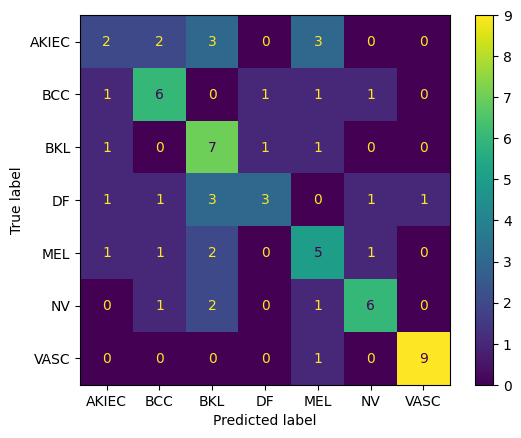

In [ ]:
disp.plot()
plt.show()

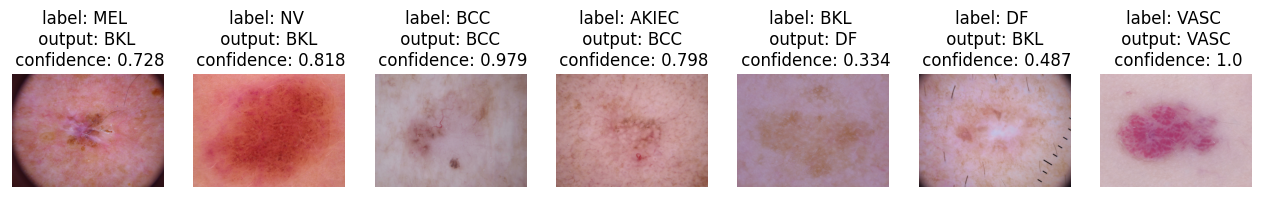

In [ ]:
# Example image
plt.figure(figsize=(16, 14))
for j in range(7):
  plt.subplot(1,7,j+1)
  plt.imshow(mpimg.imread(test_df.image[j]))
  plt.axis("off")
  plt.title(f"label: {test_df.label[j]} \n output: {test_df.output[j]} \n confidence: {round(float(test_df.confidence[j]), 3)}")
